In [26]:
from typing import Tuple, List
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import joblib
import scipy.stats

try:
    import Orange
    orange_imported = True 
except ModuleNotFoundError:
    print("orange3 not available")
    orange_imported = False

# Global settings
sns.set_style('ticks')
memory = joblib.Memory("data/cache", verbose = 0)

## Overview

This file aims to analyze results and create figures for the Experiments.
The class **RunLog** collects logs for a single **Problem** across search strategies:

**Problems**: svm, xgboost, rpart, glmnet, knn, rf.
**Search Strategies**: 
- mupluslambda: EA described in the paper
- random_search: Random Search on the Grammar employed for the EA. Used as a baseline
- True (constants_only): EA, but only constant, non-symbolic terminals

Each RunLog contains several replications of each search strategy on each task, identifyable by the 'run' column.


####  Expected file structure.
The working directory of the notebook server should contain:
 - `figures/`
 - `/run/results2/` in which all the `{problem}_{search}` folders are contained

In [27]:
class Runlog:
    """
    Read logs for a given problem across several searches
    """
    def __init__(self, problem: str, searches: List, logdir: str):
        self.problem = problem
        self.searches = searches
        self.logdir = logdir
    
    @property
    def data(self):
        df = pd.DataFrame([])
        for search in self.searches:
            df = df.append(read_run_logs(problem=self.problem, search=search, target="evaluations", dir=self.logdir))
        return df
    
    @property
    def trace_data(self):
        df = pd.DataFrame([])
        for search in self.searches:
            df = df.append(read_trace_logs(problem=self.problem, search=search, dir=self.logdir))
        return df
    
    def pick_final_expression(self, method = "best", **kwargs):
        """
        Pick final expression on "in" data
        :method: either "relative", "shortest" or "best"
        """
        df = self.data.copy()
        df = df[df['expression'].str.contains(',')]
        df = get_final_paretofront(df)
        df = df.pivot_table(index=["run", "task", "gen", "length", "problem", "search", "expression"], columns="inout", values="score")
        df = df.reset_index()
        if method == "shortest":
            out = df[df.groupby(['run', 'search'])['length'].transform(min) == df['length']]
        elif method == "relative":
            out = df.loc[[pick_relative(group, **kwargs) for name, group in df.groupby(['run', 'search'])]]
        elif method == "cheat":
            out = df[df.groupby(['run', 'search'])['out'].transform(max) == df['out']]
        elif method == "scalarize":
            out = df.loc[[pick_scalarize(group, **kwargs) for name, group in df.groupby(['run', 'search'])]]
        elif method == "shortest_top_n":
            out = df.loc[[pick_shortest_top_n(group, **kwargs) for name, group in df.groupby(['run', 'search'])]]
        else:
            out = df[df.groupby(['run', 'search'])['in'].transform(max) == df['in']]
        return out
    
    def get_benchmark_performances(self):
        """
        Load benchmark performances
        """
        df = self.data[~self.data['expression'].str.contains(',')]
        df = df.pivot_table(index=["run", "task","problem", "search", "expression"], columns="inout", values="score")
        df = df.reset_index()
        df = df[["task", "problem", "expression", "in", "out"]]
        df.drop_duplicates(inplace=True)
        return(df)

### Pick Strategies

def pick_relative(x, eps=0.01, max_steps=1):
    """
    Pick by relative improvement; 
    Consider only at most `max_steps` longer, if better by 'eps', break if not
    """
    x = x.copy()
    if len(x) == 1:
        return(x.index.values[0])
    
    use_ix, length, score = None, 0, 0
    for ix, rw in x.iterrows():
        if rw['length'] - length > max_steps:
            break  # candidates are too big
        if rw['in'] - score < eps:
            continue  # not enough increase
        use_ix, length, score = ix, rw['length'], rw['in']        
    return use_ix

def pick_scalarize(x, b: float):
    """
    Pick by scalarizing length and fitness; 
    Consider only at most `max_steps` longer, if better by 'eps', break if not
    """
    x = x.copy()
    x["scalar_score"] = x["in"] - b * (x["length"] - 1)
    return x["scalar_score"].idxmax()
    
def pick_shortest_top_n(x, n: float):
    """
    Pick by scalarizing length and fitness; 
    Consider only at most `max_steps` longer, if better by 'eps', break if not
    """
    df = x.sort_values("in").idx[:2,]
    return df["length"].idxmin()


@memory.cache()
def read_run_logs(problem:str, search: str, target: str, dir: str):
    """
    Read all log-files for a given problem x search combination
    """
    log_dir = f"{dir}/{problem}_{search}/"
    if os.path.isdir(log_dir):
        dirs = [os.path.join(log_dir, f) for f in os.listdir(log_dir)]
        df = pd.DataFrame([])
        for dir in dirs:
            file = f"{dir}/{target}.csv"
            if os.path.isfile(file):
                tmpdf = pd.read_csv(file, sep=";")
                tmpdf['search'] = search
                # Pivot random search, rename constants only
                if search == "random_search":
                    tmpdf['search'] = tmpdf.apply(lambda x: x['search']+'_'+str((x['gen'] + 1)*100), axis=1)  
                    tmpdf['endresult'] = True
                elif search == "True":
                    tmpdf['search'] = "constants_only"
                df = df.append(tmpdf)
        # Rename rf and add problem columns
        if problem == "rf": 
            df['problem'] = "random forest"
        else:
            if problem == "glmnet": 
                df = df[df["expression"] != "sklearn_default"] # ElasticNet sklearn/glmnet implementations don't match
            df['problem'] = problem
        return df
    else:
        print(log_dir,'is not path')
        


def get_final_paretofront(df: pd.DataFrame):
    """
    Filter pareto front
    """
    return df[df.endresult]
    
def read_trace_logs(problem:str, search: str, dir: str):
    """
    Read "progress" log-files for a given problem x search combination (Optimization Traces)
    """
    log_dir = f"{dir}/{problem}_{search}/"
    if os.path.isdir(log_dir):
        dirs = [os.path.join(log_dir, f) for f in os.listdir(log_dir)]
        df = pd.DataFrame([])
        for dir in dirs:
            file = f"{dir}/progress.csv"
            if os.path.isfile(file):
                tmpdf = pd.read_csv(file, sep=";")
                tmpdf['search'] = search
                if search == "True":
                    tmpdf['search'] = "constants_only"
                elif search == "random_search":
                    tmpdf['generation'] = (tmpdf['generation'] + 1)*100
                df = df.append(tmpdf)

        # Rename and add problem
        if problem == "rf": 
            df['problem'] = "random forest"
        else: 
            df['problem'] = problem
        return df


### Log Collection:
**log** is a dict of all logs in the **logdir**(here `/runs/results2`) folder. 

Most of the time we are only interested in a single individual from the pareto-front per log.
We can obtain this via `pick_final_expression(<strategy>)` from each log.

In [28]:
# Collect logs for all problems
problems = ['svm', 'glmnet', 'rf', 'rpart', 'knn', 'xgboost']
search_strategies = ["mupluslambda", "random_search", "True"]
log = {}
for problem in problems:
    log[problem] = Runlog(problem, search_strategies, logdir="runs/results3")

In [29]:
# Get final expression acording to some pick strategy data. 
# Columns 'in' and 'out' refer to in- and out-of-sample performance
df = pd.DataFrame([])

for k in log.keys():
    pdf = log[k].pick_final_expression("best")
    pdf['problem'] = k
    df = df.append(pdf)
df[['task', 'length', 'problem', 'search', 'expression', 'in', 'out']].head()

inout,task,length,problem,search,expression,in,out
0,23,1,svm,constants_only,"make_tuple(1073, 0.0010463920660818081)",0.8616,0.9158
1,53,1,svm,constants_only,"make_tuple(180, 0.002485554605757483)",0.8604,0.9240
2,53,2,svm,constants_only,"make_tuple(add(181, 0.7942504205351975), 0.002...",0.8604,0.9240
8,9957,6,svm,mupluslambda,"make_tuple(min(po, sub(truediv(m, mcp), xvar))...",0.9069,0.9650
10,31,3,svm,random_search_100,"make_tuple(min(m, p), truediv(mkd, xvar))",0.9013,0.9504


### Data Overview - Experiment Counts
We run $10$ replications of each algorithm across all tasks & searches.


In [30]:
overview = df.groupby(["problem", "search"])["task"].apply(lambda x: pd.Series({"N":len(x), "N_tasks":x.nunique()})).reset_index().pivot_table(index = ["problem", "search"],columns="level_2", values="task").reset_index()
overview["pct"] = overview.N / (overview.N_tasks * 10)
overview

level_2,problem,search,N,N_tasks,pct
0,glmnet,constants_only,1339,114,1.174561
1,glmnet,mupluslambda,1291,114,1.132456
2,glmnet,random_search_100,1201,114,1.053509
3,glmnet,random_search_200,1167,114,1.023684
4,glmnet,random_search_300,1131,114,0.992105
5,knn,constants_only,1467,116,1.264655
6,knn,mupluslambda,1425,116,1.228448
7,knn,random_search_100,1235,116,1.064655
8,knn,random_search_200,1174,116,1.012069
9,knn,random_search_300,1128,116,0.972414


---
### Experiment 1: Efficacy of EA algorithm: 
Boxplot of mu+lambda EA versus random search.
We only analyze performance on hold-out data, as this is what we are interested in
Open Question: Do we average before plotting?

### Performance
The following boxplot shows normalized accuracy across problems and search strategies

**1. Un-aggregated (across all replications):**

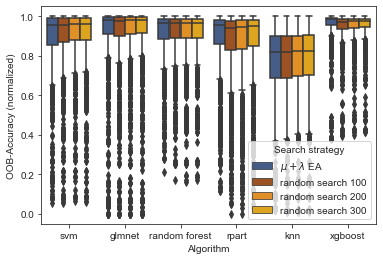

In [31]:
sns.set_palette([sns.xkcd_rgb[x] for x in ["denim blue", "burnt sienna", "tangerine", "yellow orange"]])
data = df[df.search != "constants_only"].copy()
data.replace("rf", "random forest", inplace=True)
p = sns.boxplot(data=data, x="problem", y="out", hue = "search")
p.set(ylabel='OOB-Accuracy (normalized)', xlabel='Algorithm')
p.legend(loc='lower right')
p.legend_.set_title("Search strategy")
if "mupluslambda_ho" in data["search"].values:
    new_labels = [r'$\mu + \lambda$ HO-EA', r'$\mu + \lambda$ EA', 'random search 100', 'random search 200', 'random search 300']
else:
    new_labels = [r'$\mu + \lambda$ EA', 'random search 100', 'random search 200', 'random search 300']
for t, l in zip(p.legend_.texts, new_labels): t.set_text(l)
plt.show()

**2. Aggregated across replications:**

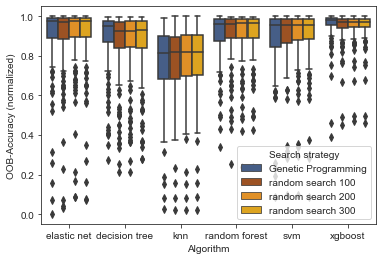

In [32]:
sns.set_palette([sns.xkcd_rgb[x] for x in ["denim blue", "burnt sienna", "tangerine", "yellow orange"]])
aggdf = data.groupby(["task", "search","problem"]).agg(np.mean).reset_index()
aggdf["problem"].replace('glmnet', "elastic net", inplace=True)
aggdf["problem"].replace('knn', "knn", inplace=True)
aggdf["problem"].replace('rpart', "decision tree", inplace=True)
p = sns.boxplot(data=aggdf, x="problem", y="out", hue = "search", order = ["elastic net", "decision tree", "knn", "random forest", "svm", "xgboost"])
p.set(ylabel='OOB-Accuracy (normalized)', xlabel='Algorithm')
p.legend(loc='lower right')
p.legend_.set_title("Search strategy")
if "mupluslambda_ho" in aggdf["search"].values:
    new_labels = [r'$\mu + \lambda$ EA', r'$\mu + \lambda$ HO-EA', 'random search 100', 'random search 200', 'random search 300']
else:
    new_labels = ['Genetic Programming', 'random search 100', 'random search 200', 'random search 300']
for t, l in zip(p.legend_.texts, new_labels): t.set_text(l)
plt.savefig("figures/experiment_1.pdf", bbox_inches='tight', pad_inches=.1)
plt.show()

**Comparing OOB Accuracy for not-converged vs. converged**

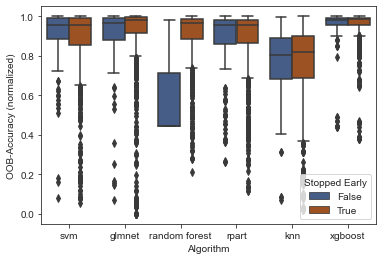

In [33]:
sns.set_palette([sns.xkcd_rgb[x] for x in ["denim blue", "burnt sienna"]])
convergence = data.copy()[data.search == "mupluslambda"]
convergence['stopped early'] = convergence.gen != 299

p = sns.boxplot(data=convergence, x="problem", y="out", hue="stopped early")

p.set(ylabel='OOB-Accuracy (normalized)', xlabel='Algorithm')
p.legend(loc='lower right')
p.legend_.set_title("Stopped Early")
plt.show()

3. **Hypothesis Tests:**

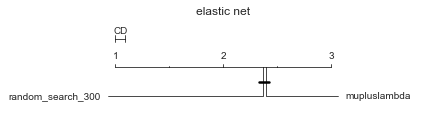

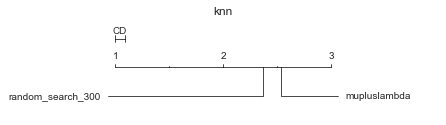

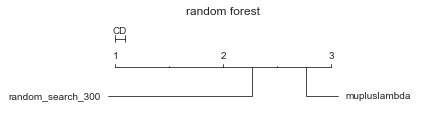

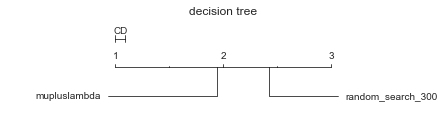

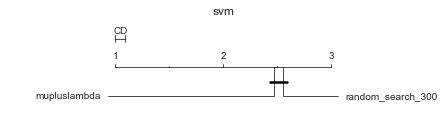

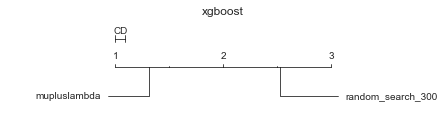

In [34]:
if orange_imported:
    aggdf["out_rank"] = aggdf.groupby(["task", "problem"]).out.rank(ascending=False)
    aggdf2 = aggdf.groupby(["problem", "search"])["out_rank"].mean().reset_index()
    aggdf2 = aggdf2[~aggdf2["search"].isin(["random_search_100", "random_search_200"])]

    for problem in aggdf.problem.unique():
        data = aggdf2[aggdf2.problem == problem]
        names = data["search"].values
        avg_ranks = data["out_rank"].values
        cd = Orange.evaluation.compute_CD(avg_ranks, len(aggdf[aggdf.problem == problem]))
        Orange.evaluation.graph_ranks(avg_ranks, names, cd=cd, width=6, textspace=1.5)
        plt.title(problem)
        plt.show()
else:
    print("orange not available")

### Efficiency
Here we investiage the average number of generations required to converge

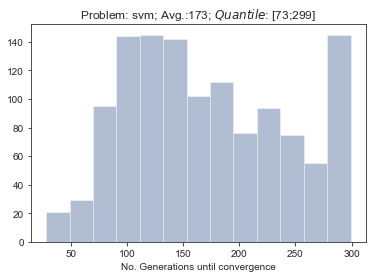

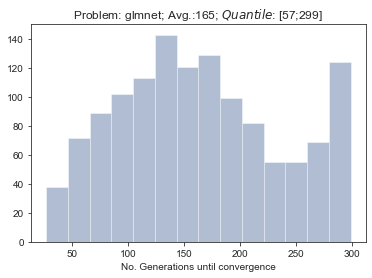

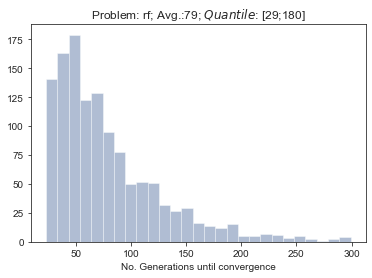

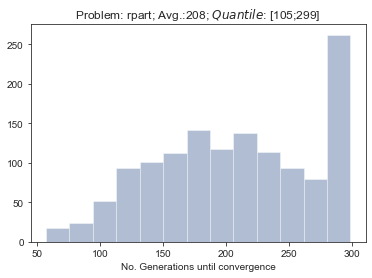

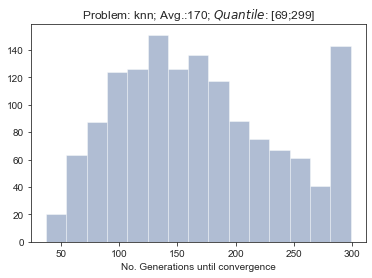

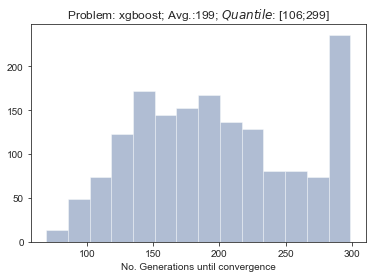

In [35]:
for problem in df.problem.unique():
    data = df[(df.search == "mupluslambda") & (df.problem == problem)]["gen"]
    p = sns.distplot(data, kde=False)
    p.set(xlabel='No. Generations until convergence')
    p.set_title(f'Problem: {problem}; Avg.:{round(data.mean()):.0f}; $Quantile$: [{data.quantile(.05):.0f};{data.quantile(.95):.0f}]')
    plt.show()

In [36]:
#Get optimization traces
tdf = pd.DataFrame([])
for k in log.keys():
    tdf = tdf.append(log[k].trace_data)
tdf.head()

,run,task,generation,score_min,score_avg,score_max,search,problem
0,4e782103-002a-47ed-8da9-2e42830955e9,10106,0,0.675050,0.811639,0.889567,mupluslambda,svm
1,4e782103-002a-47ed-8da9-2e42830955e9,10106,1,0.838892,0.882648,0.896834,mupluslambda,svm
2,4e782103-002a-47ed-8da9-2e42830955e9,10106,2,0.883405,0.890554,0.896852,mupluslambda,svm
3,4e782103-002a-47ed-8da9-2e42830955e9,10106,3,0.884762,0.892471,0.898070,mupluslambda,svm
4,4e782103-002a-47ed-8da9-2e42830955e9,10106,4,0.885287,0.893573,0.898070,mupluslambda,svm


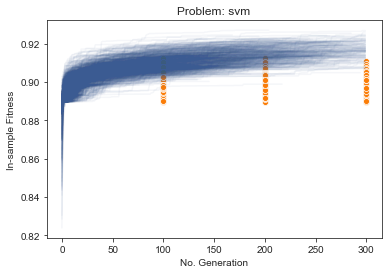

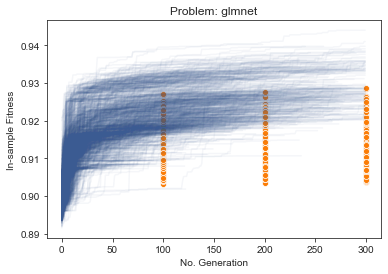

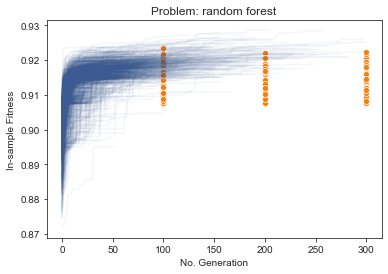

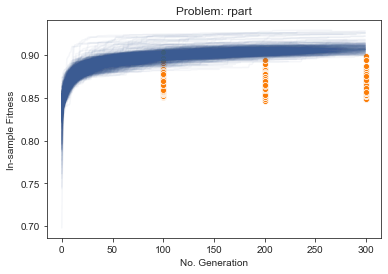

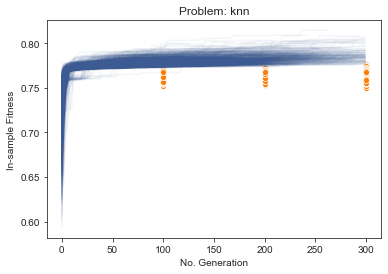

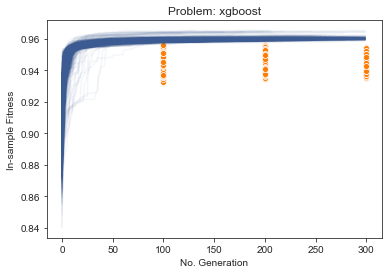

In [37]:
# Trace plots: random search (orange) vs mupluslambda (blue)
for problem in tdf.problem.unique():
    data = tdf[(tdf.search == "mupluslambda") & (tdf.problem == problem)]
    p = sns.lineplot(data=data, x="generation", y="score_max", hue="search", units="run", estimator=None, alpha=0.05)
    data = tdf[(tdf.search == "random_search") & (tdf.problem == problem)]
    p = sns.scatterplot(data=data, x="generation", y="score_max", color=sns.xkcd_rgb["pumpkin orange"], alpha=1.)
    p.legend_.remove()
    p.set(xlabel='No. Generation', ylabel="In-sample Fitness")
    p.set_title(f'Problem: {problem}')
    plt.savefig(f"figures/opt_traces_{problem}.png", bbox_inches='tight', pad_inches=.1)
    plt.show()

### Conclusions
- mupluslambda is more efficient, finds better in-sample solutions
- small differences in out-of-sample solutions (perhaps slight overfitting)

## Experiment 2: Benchmarking symbolic defaults

### Experiment 2.1: Benchmarking symbolic defaults on surrogates

Compare results to:
- Implementation defaults
- Static defaults
- Optimistic Random Search

In [38]:
# Collect implementation default performances
cols = ["task", "problem", "search", "in", "out"]
baselines = pd.DataFrame([])
for k in log.keys():
    bdf = log[k].get_benchmark_performances().rename(columns={"expression":"search"})[cols]
    bdf['problem'] = k
    baselines = baselines.append(bdf)

baselines.head()

inout,task,problem,search,in,out
0,9957,svm,mlr_default,0.8842,0.9625
1,9957,svm,sklearn_default,0.8866,0.9625
2,9957,svm,symbolic_best,0.8944,0.9730
3,31,svm,mlr_default,0.8843,0.9501
4,31,svm,sklearn_default,0.8869,0.9340


In [39]:
# Collect optimistic random search performances
cols = ["task", "problem", "search", "in", "out"]
rsdf =  pd.DataFrame([])
for problem in problems:
    file = f"data/mlr_{problem}_baselines.csv"
    if os.path.isfile(file):
        prsdf = pd.read_csv(f"data/mlr_{problem}_baselines.csv", index_col=0).transpose()
        prsdf['task'] = [int(float(x)) for x in prsdf.index.values]
        prsdf = prsdf.melt(id_vars='task').rename(columns={"search_type":"search", "value":"out"})
        prsdf['problem'] = problem
        prsdf['in'] = np.nan
        prsdf = prsdf[prsdf['search'] != 'oracle']
        rsdf = rsdf.append(prsdf[cols])

rsdf.head()

,task,problem,search,in,out
106,3,svm,rs_2,NaN,0.615487
107,6,svm,rs_2,NaN,0.599002
108,11,svm,rs_2,NaN,0.730493
109,12,svm,rs_2,NaN,0.566405
110,14,svm,rs_2,NaN,0.502232


In [40]:
# Selected defaults
random_search = pd.read_csv("data/random_search_30k.csv", sep=";")
xgb = pd.read_csv("data/random_search_30k_xgb.csv", sep=";")
random_search = random_search.append(xgb)
random_search = random_search.pivot_table(index=["task", "problem", "search"], values="score", columns="inout").reset_index()
random_search.search.replace("random_search_3000", "random_search", inplace=True)
random_search.search.replace("random_search_300", "random_search", inplace=True)
random_search.problem.replace("random forest", "rf", inplace=True)

In [41]:
cols = ["task", "problem", "search", "in", "out"]
srdf = df[cols].append(baselines).append(rsdf).append(random_search)
srdf.search.replace("random_search", "symbolic_default", inplace=True)
srdf.search.replace("constants_only", "constant_default", inplace=True)

# Average out-of-sample performances
srdf.groupby(['problem', 'search']).mean()[["out"]]

inout                           out
problem search                     
glmnet  constant_default   0.858052
        mlr_default        0.814650
        mupluslambda       0.896576
        random_search_100  0.888642
        random_search_200  0.893578
...                             ...
xgboost rs_64              0.968107
        rs_8               0.916939
        sklearn_default    0.939737
        symbolic_best      0.934224
        symbolic_default   0.951114

[87 rows x 1 columns]

**Unaggregated Boxplots:**

In [42]:
import re 
filter_search = ['random_search_100', 'random_search_200', 'random_search_300', 'rs_64', 'rs_128', 'symbolic_best']
psrdf = srdf[~srdf.search.isin(filter_search)].copy()
psrdf["search"] = [re.sub("rs_", "opt. rs ", x) for x in psrdf["search"].values]
psrdf["search"] = [re.sub("_", " ", x) for x in psrdf["search"].values]

order  = ["mlr default",   "sklearn default", "symbolic default", "constant default"]+["opt. rs "+str(x) for x in [2, 4, 8,16,32]]
colors = ["darkish green", "jade green",  "marine blue" , "dusty purple"  ]
colors = sns.xkcd_palette(colors) + sns.light_palette("orange", 5)[1:] + sns.xkcd_palette(["vermillion"])
color_dict = dict(zip(order, colors))

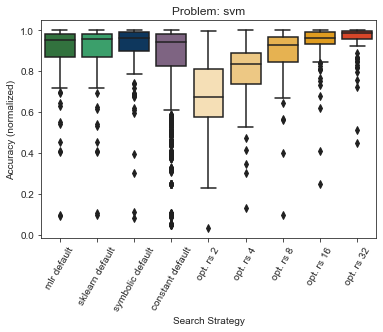

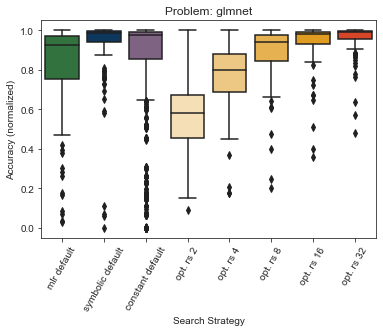

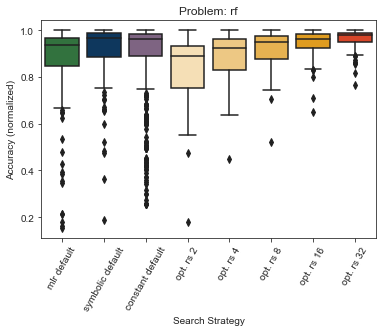

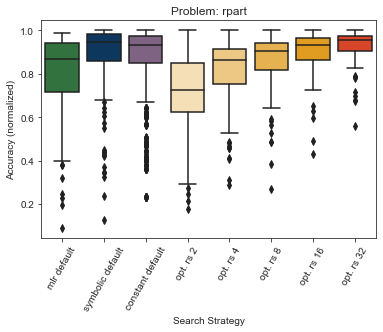

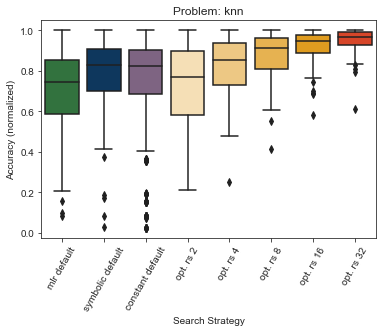

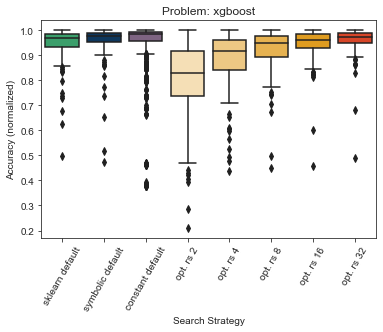

In [43]:
for problem in srdf.problem.unique():
    psrdf2 = psrdf[psrdf["problem"] == problem]
    if len(psrdf):
        order2 = [x for x in order if x in psrdf2.search.values]
        p = sns.boxplot(data=psrdf2, x="search", y="out", palette = color_dict, order=order2)
        p.set_xticklabels(p.get_xticklabels(), rotation=60)
        p.set(ylabel='Accuracy (normalized)', xlabel='Search Strategy')
        p.set_title(f'Problem: {problem}')
        plt.show()

**Aggregated across replications**

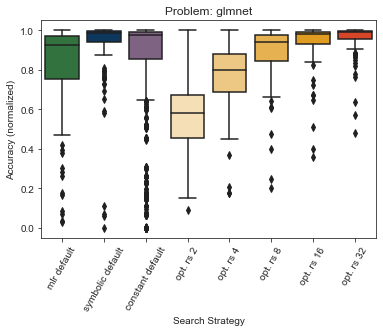

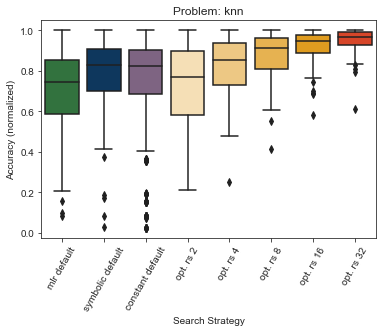

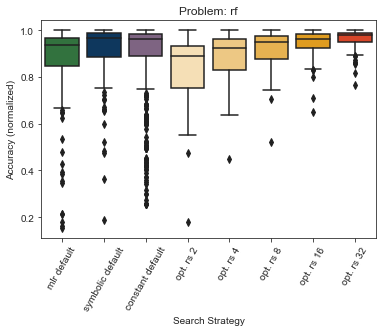

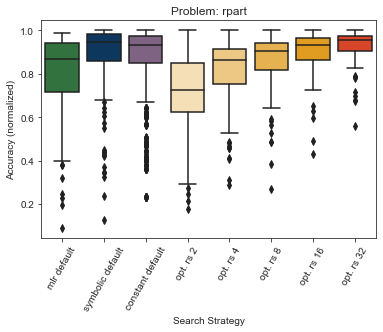

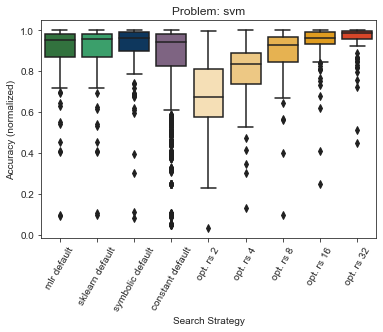

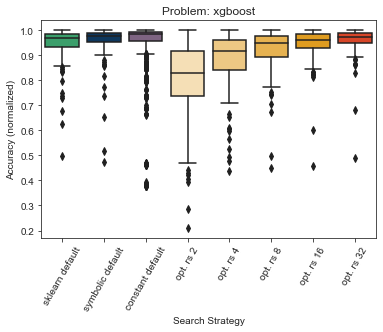

In [44]:
aggsrdf = psrdf.groupby(['problem', 'search', "task"]).mean().reset_index()

for problem in aggsrdf.problem.unique():
    psrdf2 = psrdf[psrdf["problem"] == problem]
    if len(psrdf2):
        order2 = [x for x in order if x in psrdf2.search.values]
        p = sns.boxplot(data=psrdf2, x="search", y="out", palette = color_dict, order=order2)
        p.set_xticklabels(p.get_xticklabels(), rotation=60)
        p.set(ylabel='Accuracy (normalized)', xlabel='Search Strategy')
        p.set_title(f'Problem: {problem}')
        plt.savefig(f"figures/boxplots_surrogates_agg_{problem}.pdf", bbox_inches='tight', pad_inches=.1)
        plt.show()

**Boxplots rescaled to min-max**

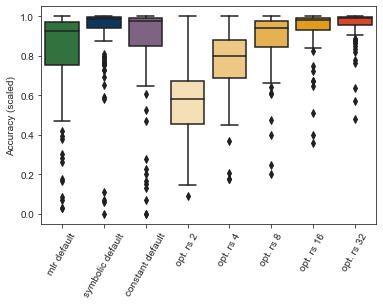

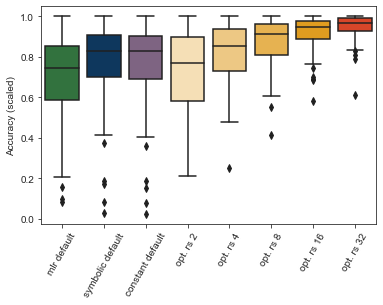

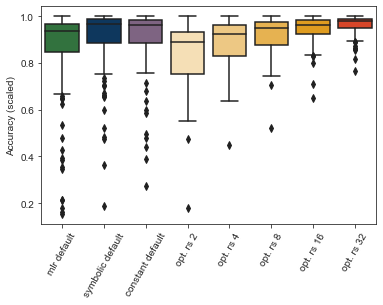

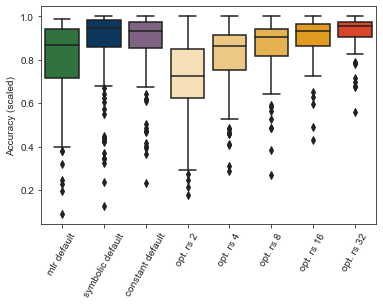

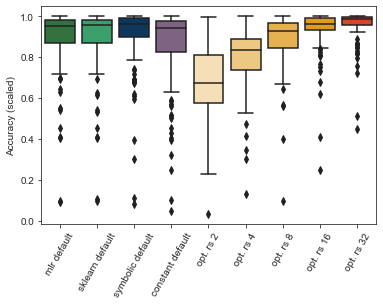

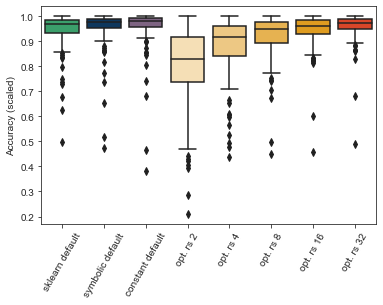

In [45]:
# Rescale to [0, 1]
aggsrdf = psrdf.groupby(['problem', 'search', "task"]).mean().reset_index()
for problem in aggsrdf.problem.unique():
    ppsrdf = aggsrdf[~aggsrdf.search.isin(filter_search)]
    ppsrdf = ppsrdf[ppsrdf["problem"] == problem]
    if len(psrdf):
        order2 = [x for x in order if x in ppsrdf.search.values]
        psrdf["out"] = ppsrdf.groupby("task")["out"].apply(lambda x: (x - min(x)) / (max(x) - min(x)))
        p = sns.boxplot(data=ppsrdf, x="search", y="out", palette = color_dict, order=order2)
        p.set_xticklabels(p.get_xticklabels(), rotation=60)
        p.set(ylabel='Accuracy (scaled)', xlabel=None)
        #p.set_title(f'Problem: {problem}')
        plt.savefig(f"figures/boxplots_surrogates_rescaled_agg_{problem}.pdf", bbox_inches='tight', pad_inches=.1)
        plt.show()

In [46]:
# Plot some expression
df[df.problem == "rpart"]["expression"]

7        make_tuple(mul(mcp, 0.00217792113335539), add(...
9        make_tuple(0.00042850217026338026, 25, 11, add...
11       make_tuple(mul(0.012364849750475951, mcp), mul...
13       make_tuple(if_gt(rc, p, mcp, 0.002194983756931...
16       make_tuple(neg(sub(n, 0.6337922858588115)), ad...
                               ...                        
20626    make_tuple(truediv(0.00367888483817517, m), 26...
20628    make_tuple(truediv(0.006989947585317687, po), ...
20630    make_tuple(mul(0.0018089285876242251, mcp), mi...
20632    make_tuple(mul(0.0018089285876242251, mcp), mi...
20642    make_tuple(mul(mul(0.002893072128386169, mcp),...
Name: expression, Length: 6153, dtype: object

**Scatter Plots for performance comparison**

**mu+lambda vs constants**

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


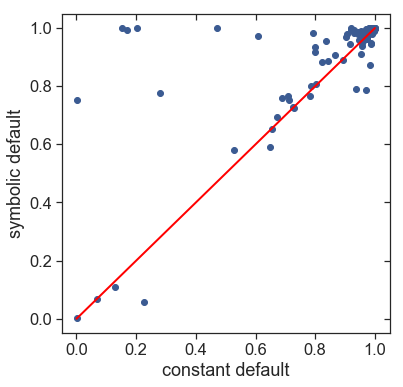

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


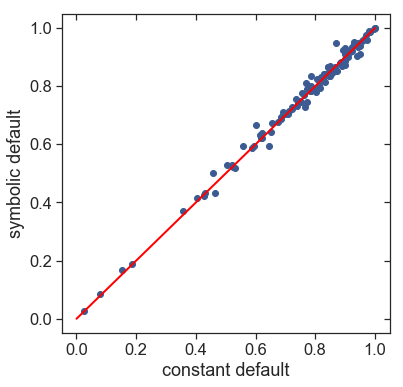

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


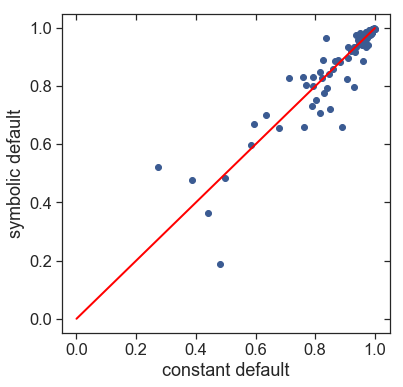

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


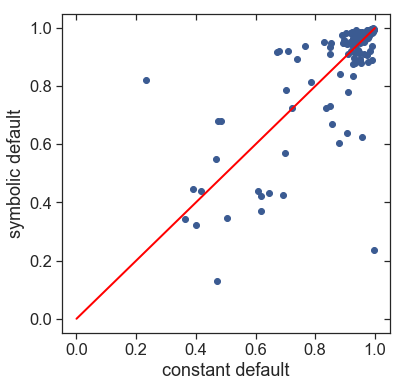

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


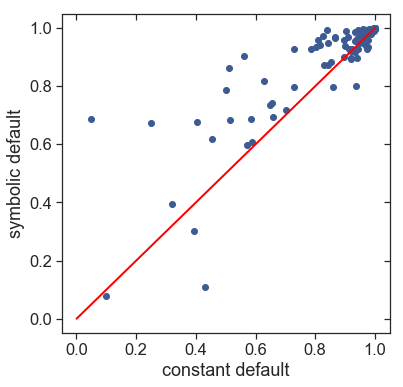

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


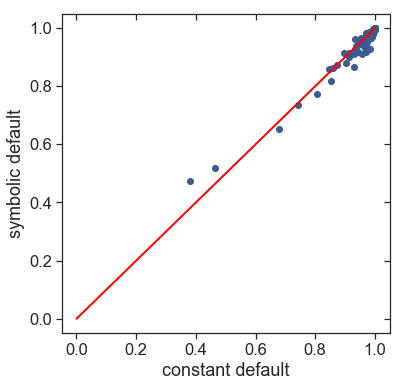

In [47]:
# Scatter plot x mulambda vs constants and perhaps random search
y = ["symbolic default"]
x = ["constant default"]

for problem in aggsrdf.problem.unique():
    psrdf = aggsrdf[~aggsrdf.search.isin(filter_search)]
    psrdf = psrdf[psrdf["problem"] == problem]
    psrdf = psrdf[psrdf.search.isin(x+y)].pivot_table(index="task", columns="search",  values="out")
    if len(psrdf) and psrdf.shape[1] > 1:
        with sns.plotting_context("notebook", font_scale=1.5):
            grid = sns.JointGrid(psrdf[x].values, psrdf[y].values, space=0, size=6, ratio=50)
            grid.plot_joint(plt.scatter)
            grid.ax_joint.set_xlabel(*x)
            grid.ax_joint.set_ylabel(*y)
            #plt.title(problem)
            plt.plot([0.,1.], [0.,1.], "b-", linewidth = 2, color = "red")
            #plt.plot([0.,1.], [0.05,1.05], "b-", linewidth = .5, color = "orange")
            #plt.plot([0.,1.], [-0.05,.95], "b-", linewidth = .5, color = "orange")
            plt.savefig(f"figures/scatter_vs_constants_surrogates_{problem}.pdf", bbox_inches='tight', pad_inches=.1)
            plt.show()

**mu+lambda vs random_search x 8**

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


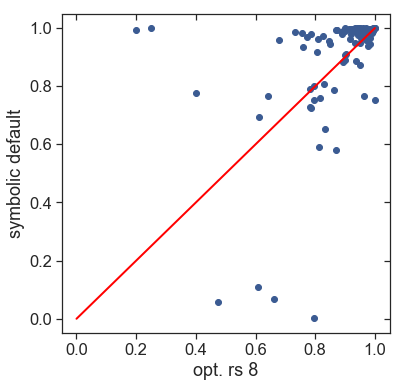

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


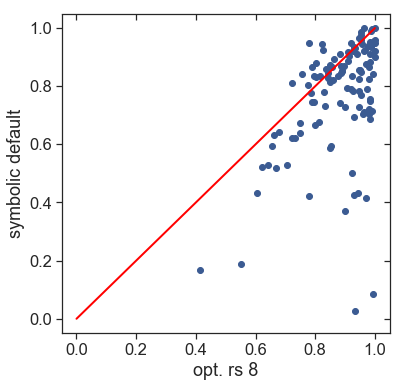

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


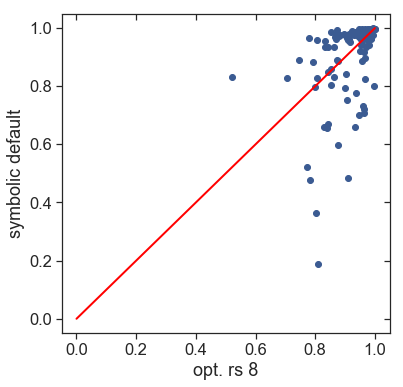

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


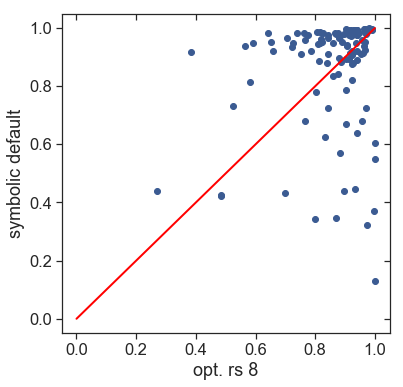

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


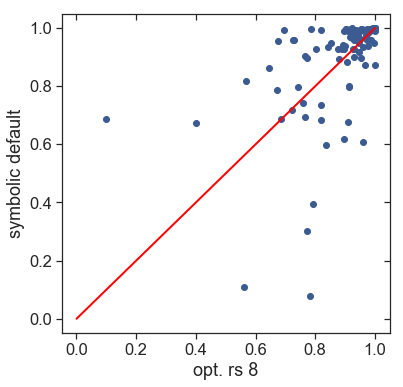

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


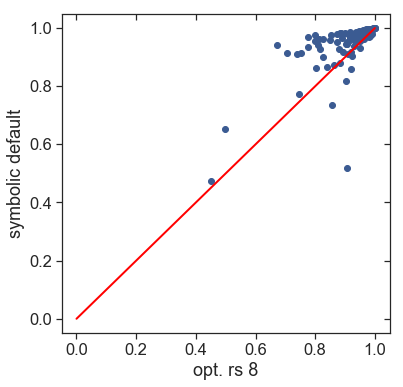

In [48]:
# Scatter plot x mulambda vs constants and perhaps random search
y = ["symbolic default"]
x = ["opt. rs 8"]

for problem in aggsrdf.problem.unique():
    psrdf = aggsrdf[~aggsrdf.search.isin(filter_search)]
    psrdf = psrdf[psrdf["problem"] == problem]
    psrdf = psrdf[psrdf.search.isin(x+y)].pivot_table(index="task", columns="search",  values="out")
    if len(psrdf) and psrdf.shape[1] > 1:
        with sns.plotting_context("notebook", font_scale=1.5):
            grid = sns.JointGrid(psrdf[x].values, psrdf[y].values, space=0, size=6, ratio=50)
            grid.plot_joint(plt.scatter)
            grid.ax_joint.set_xlabel(*x)
            grid.ax_joint.set_ylabel(*y)
            #plt.title(problem)
            plt.plot([0.,1.], [0.,1.], "b-", linewidth = 2, color = "red")
            plt.savefig(f"figures/scatter_vs_rs8_surrogates_{problem}.pdf", bbox_inches='tight', pad_inches=.1)
            plt.show()

#### Table with averages

In [49]:
# Aggregate average performance across tasks
data = aggsrdf.groupby(["problem", "search"]).agg(np.mean)[["out"]].reset_index().pivot_table(index="problem", columns="search", values="out")
data2 = aggsrdf.groupby(["problem", "search"]).agg(np.std)[["out"]].reset_index().pivot_table(index="problem", columns="search", values="out")
data = data[["symbolic default", "constant default", "mlr default", "sklearn default",  "opt. rs 8"]]
data2 = data2[["symbolic default", "constant default", "mlr default", "sklearn default",  "opt. rs 8"]]
data.loc[["svm", "xgboost"], "mlr default"] = data.loc[["svm", "xgboost"], "sklearn default"] 
data2.loc[["svm", "xgboost"], "mlr default"] = data2.loc[["svm", "xgboost"], "sklearn default"] 
data = data.drop("sklearn default", axis=1).rename(columns={"symbolic default":"symbolic", "constant default":"constant", "mlr default":"impl. default"})
data2 = data2.drop("sklearn default", axis=1).rename(columns={"symbolic default":"symbolic", "constant default":"constant", "mlr default":"impl. default"})
data = data.apply(round, ndigits=3)
data2 = data2.apply(round, ndigits=3)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        data.iloc[i,j] = f"{data.iloc[i,j]}({data2.iloc[i,j]})"
print(data.to_latex())

\begin{tabular}{lllll}
\toprule
search &      symbolic &      constant & impl. default &     opt. rs 8 \\
problem &               &               &               &               \\
\midrule
glmnet  &  0.913(0.188) &  0.864(0.241) &  0.815(0.244) &  0.888(0.141) \\
knn     &  0.769(0.193) &  0.766(0.195) &     0.71(0.2) &  0.877(0.112) \\
rf      &  0.906(0.142) &  0.908(0.136) &  0.854(0.202) &  0.921(0.075) \\
rpart   &  0.858(0.198) &  0.868(0.169) &    0.789(0.2) &   0.86(0.133) \\
svm     &   0.896(0.17) &  0.851(0.206) &  0.887(0.169) &  0.885(0.135) \\
xgboost &  0.951(0.081) &  0.956(0.087) &   0.94(0.079) &  0.917(0.091) \\
\bottomrule
\end{tabular}



**Variance of Results**

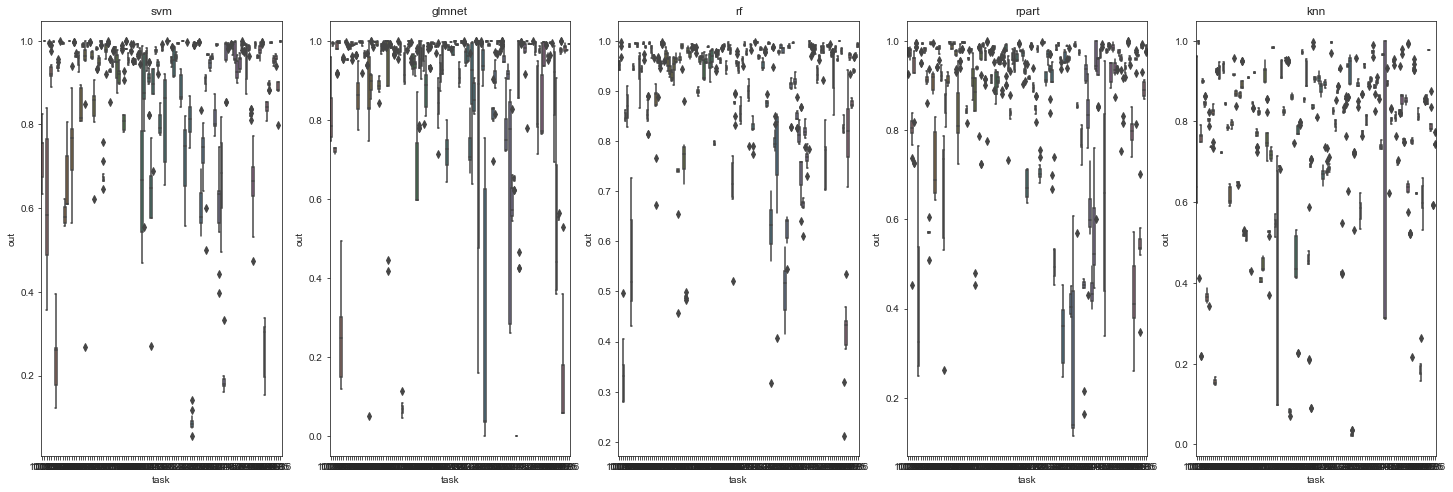

In [50]:
a = df.copy()
a = a[(a.search == "mupluslambda") & (a.expression.str.contains(','))]
a['task'] = a.task.astype(str)
fig, axes =  plt.subplots(1, 5, figsize=(25, 8))
for ax, problem in zip(axes.flatten(), problems):
    b = a[a.problem == problem].sort_values(by=["out"])
    sns.boxplot(data=b, x="task", y="out", ax=ax)
    ax.set_title(problem)

**Critical Differences and Average Ranks**

**symbolic best**: cost:16, lambda: mkd/xvar  || This was never reported in literature

glmnet : FriedmanchisquareResult(statistic=2182865.5333333327, pvalue=0.0)
117


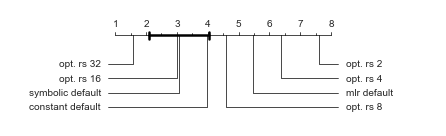

knn : FriedmanchisquareResult(statistic=8558584.999999989, pvalue=0.0)
119


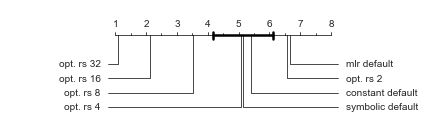

rf : FriedmanchisquareResult(statistic=668949.8148148148, pvalue=0.0)
119


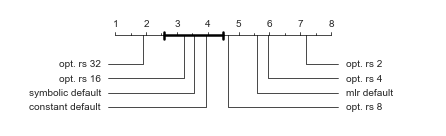

rpart : FriedmanchisquareResult(statistic=938808.294117647, pvalue=0.0)
118


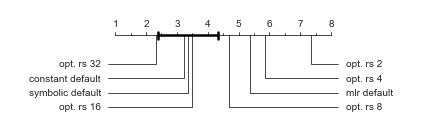

svm : FriedmanchisquareResult(statistic=6269097.142857141, pvalue=0.0)
109


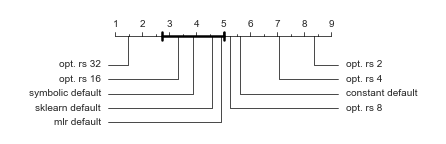

xgboost : FriedmanchisquareResult(statistic=461760.45454545453, pvalue=0.0)
118


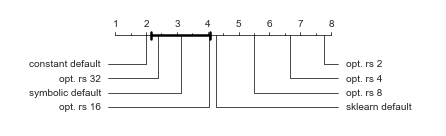

In [51]:
if orange_imported:
    # Need to find out how to annotate those CD diagrams
    aggsrdf2 = aggsrdf[~aggsrdf.search.isin(filter_search+["mupluslambda"])].copy()
    aggsrdf2["out_rank"] = aggsrdf2.groupby(["task", "problem"]).out.rank(ascending=False)
    aggsrdf2 = aggsrdf2.sort_values(["task", "problem"])
    aggdf2 = aggsrdf2.groupby(["problem", "search"])["out_rank"].mean().reset_index()

    for problem in aggdf2.problem.unique():
        data = aggdf2[aggdf2.problem == problem]
        if len(data):
            # Friedman Test: 
            cnts = aggsrdf2[aggsrdf2.problem == problem].groupby(["task"]).search.count()
            drop = cnts[cnts != cnts.max()].index.values
            ftestdata = aggsrdf2[(aggsrdf2.problem == problem) & (~aggsrdf2.task.isin(drop))]
            xar = [[x.values] for name, x in ftestdata.groupby(["search"])["out"]]
            tst = scipy.stats.friedmanchisquare(*xar)
            print(f"{problem} : {tst}")
            # Nemeny Test
            n_tasks = len(aggsrdf[aggsrdf.problem == problem].task.unique())
            print(f"{n_tasks}")
            names = data["search"].values
            avg_ranks = data["out_rank"].values
            cd = Orange.evaluation.compute_CD(avg_ranks, n_tasks)
            if tst[1] > 0.05:
                cd=None
            #import pdb; pdb.set_trace()
            cdm = [i for i,v in enumerate(names) if v == "symbolic default"]
            Orange.evaluation.graph_ranks(avg_ranks, names, cdmethod = cdm[0],cd=cd, width=6, textspace=1.5)
            # plt.title(problem)
            plt.savefig(f"figures/cd_surrogates_{problem}.pdf", bbox_inches='tight', pad_inches=.1)
            plt.show()
else:
    print("orange not available")

## Experiment 2.2: Benchmarking symbolic defaults on real data

Compare results to:
- Implementation defaults
- Static defaults

In [12]:
import re

In [13]:
# Collect real data evaluations: Implementation defaults
cols = ["task", "problem", "search", "in", "out"]

real_baseline = pd.DataFrame([])
for problem in problems:
    file = f"data/mlr_{problem}_real_data_baselines_results.csv"
    if os.path.isfile(file):
        rbdf = pd.read_csv(file).rename(columns={"default":"search", "str":"expression", "problem_name": "problem", "mmce.test.mean":"out"})
        rbdf["in"] = np.nan
        rbdf["out"] = 1 - rbdf["out"] # Compute accuracy from mmce        
        if problem == "glmnet":
            rbdf = rbdf[rbdf.search == "mlr_default"]
        if problem == "svm":
            rbdf = rbdf[rbdf.search == "sklearn_default"]
        real_baseline = real_baseline.append(rbdf[cols])

In [14]:
# Collect real data evaluations: Symbolic defaults
cols = ["task", "problem", "search", "in", "out"]
for problem in problems:
    file = f"data/mlr_{problem}_real_data_symbolic_results.csv"
    if os.path.isfile(file):
        rbdf = pd.read_csv(file).rename(columns={"default":"search", "str":"expression", "problem_name": "problem", "mmce.test.mean":"out"})
        rbdf["in"] = np.nan
        rbdf["out"] = 1 - rbdf["out"] # Compute accuracy from mmce
        real_baseline = real_baseline.append(rbdf[cols])

real_baseline["search"] = [re.sub("_", " ", x) for x in real_baseline["search"].values]
real_baseline = real_baseline.sort_values(["problem", "task"])
real_baseline.groupby(["search", "problem"])["out"].mean()

search            problem    
mlr default       mlr_glmnet     0.799585
                  mlr_knn        0.762527
                  mlr_rf         0.850276
                  mlr_rpart      0.748237
sklearn default   mlr_svm        0.840152
                  mlr_xgboost    0.849761
symbolic default  mlr_glmnet     0.818324
                  mlr_knn        0.793565
                  mlr_rf         0.805402
                  mlr_rpart      0.782727
                  mlr_svm        0.782753
                  mlr_xgboost    0.851849
Name: out, dtype: float64

### Boxplots for real data experiments

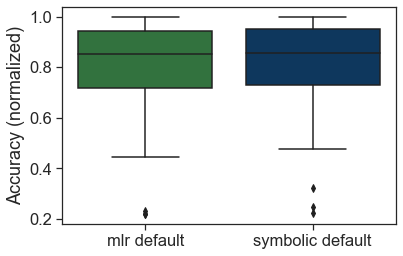

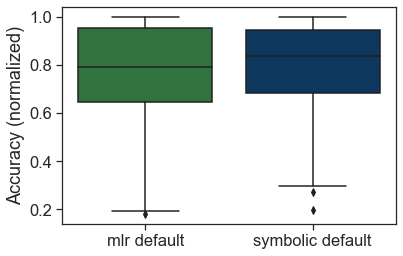

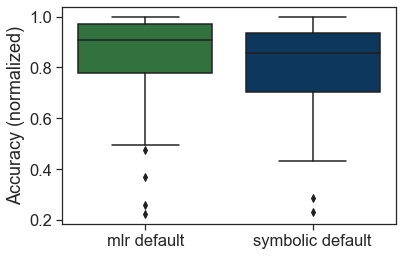

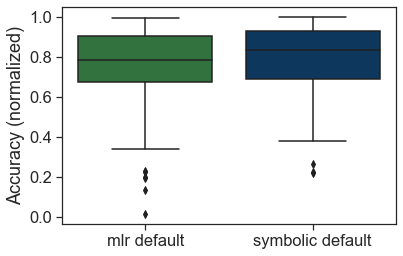

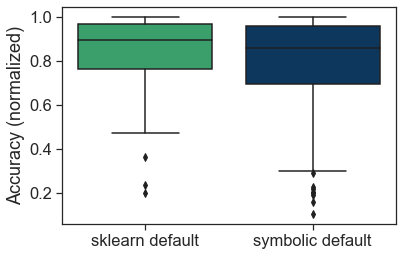

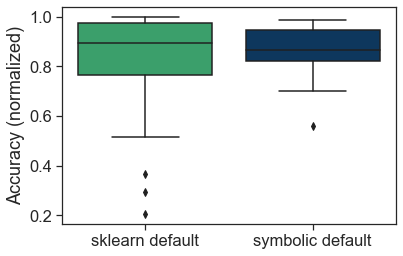

In [15]:
order  = ["mlr default",   "sklearn default",  "symbolic default", "constant default"]
colors = ["darkish green", "jade green",       "marine blue" , "dusty purple"  ]
colors = sns.xkcd_palette(colors) + sns.light_palette("orange", 5)[1:] + sns.xkcd_palette(["vermillion"])
color_dict = dict(zip(order, colors))

for problem in real_baseline.problem.unique():
    rbdf = real_baseline[real_baseline["problem"] == problem]
    if len(rbdf):
        porder = [x for x in order if x in rbdf.search.values]
        with sns.plotting_context("notebook", font_scale=1.5):     
            p = sns.boxplot(data=rbdf, x="search", y="out", order=porder, palette=color_dict)
            # p.set_xticklabels(p.get_xticklabels(), rotation=60)
            p.set(ylabel='Accuracy (normalized)', xlabel=None)#'Search Strategy')
            #p.set_title(f'Problem: {problem}')
            plt.savefig(f"figures/boxplots_realdata_{problem}.pdf", bbox_inches='tight', pad_inches=.1)
            plt.show()

In [16]:
# Aggregate average performance across tasks
real_baseline.problem = [re.sub("mlr_", "", x) for x in real_baseline.problem.values]
data = real_baseline.groupby(["problem", "search"]).agg(np.mean)[["out"]].reset_index().pivot_table(index="problem", columns="search", values="out")
data2 = real_baseline.groupby(["problem", "search"]).agg(np.std)[["out"]].reset_index().pivot_table(index="problem", columns="search", values="out")
data = data[["symbolic default", "mlr default", "sklearn default"]]
data2 = data2[["symbolic default", "mlr default", "sklearn default",]]
data.loc[["svm", "xgboost"], "mlr default"] = data.loc[["svm", "xgboost"], "sklearn default"] 
data2.loc[["svm", "xgboost"], "mlr default"] = data2.loc[["svm", "xgboost"], "sklearn default"] 
data = data.drop("sklearn default", axis=1).rename(columns={"symbolic default":"symbolic", "constant default":"constant", "mlr default":"impl. default"})
data2 = data2.drop("sklearn default", axis=1).rename(columns={"symbolic default":"symbolic", "constant default":"constant", "mlr default":"impl. default"})
data = data.apply(round, ndigits=3)
data2 = data2.apply(round, ndigits=3)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        data.iloc[i,j] = f"{data.iloc[i,j]}({data2.iloc[i,j]})"
print(data.to_latex())

\begin{tabular}{lll}
\toprule
search &      symbolic & impl. default \\
problem &               &               \\
\midrule
glmnet  &  0.818(0.166) &    0.8(0.172) \\
knn     &  0.794(0.188) &  0.763(0.204) \\
rf      &  0.805(0.166) &   0.85(0.157) \\
rpart   &  0.783(0.176) &  0.748(0.203) \\
svm     &  0.783(0.234) &   0.84(0.164) \\
xgboost &  0.852(0.129) &   0.85(0.158) \\
\bottomrule
\end{tabular}



glmnet : WilcoxonResult(statistic=914.5, pvalue=3.0558112154467353e-10)


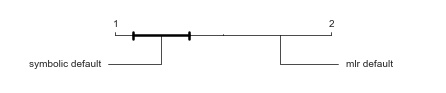

knn : WilcoxonResult(statistic=1388.0, pvalue=0.0034737653067564516)


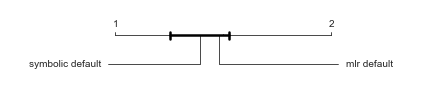

rf : WilcoxonResult(statistic=573.5, pvalue=1.0183573317420699e-12)


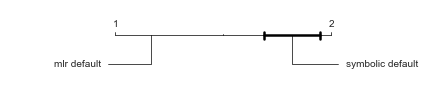

rpart : WilcoxonResult(statistic=1335.0, pvalue=2.269271341833627e-06)


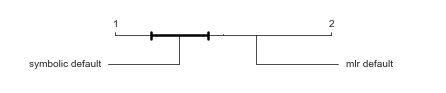

svm : WilcoxonResult(statistic=2465.0, pvalue=0.7094163704288261)


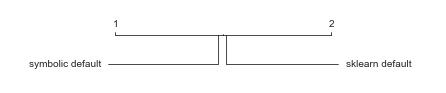

xgboost : WilcoxonResult(statistic=29.0, pvalue=0.4561258517135216)


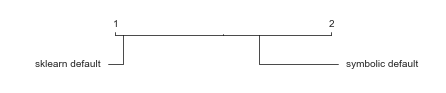

In [17]:
if orange_imported:
    # Need to find out how to annotate those CD diagrams
    real_baseline["out_rank"] = real_baseline.groupby(["task", "problem"]).out.rank(ascending=False)
    agg_real_baseline = real_baseline.groupby(["problem", "search"])["out_rank"].mean().reset_index()

    for problem in real_baseline.problem.unique():
        data = agg_real_baseline[agg_real_baseline.problem == problem]
        if len(data) > 1:
            # Friedman / Wilcox Test 
            cnts = real_baseline[real_baseline.problem == problem].groupby(["task"]).search.count()
            drop = cnts[cnts != cnts.max()].index.values
            ftestdata = real_baseline[(real_baseline.problem == problem) & (~real_baseline.task.isin(drop))]
            xar = [[x.values] for name, x in ftestdata.groupby(["search"])["out"]]
            if len(xar) == 2:
                tst = scipy.stats.wilcoxon(x=xar[0][0], y=xar[1][0], correction=True)
            elif (len(xar) > 2):
                tst = scipy.stats.friedmanchisquare(*xar)
            else: 
                tst = "No test, only one sample"
            print(f"{problem} : {tst}")
            # Nemenyi Post Hoc
            names = data["search"].values
            n_tasks = len(real_baseline[real_baseline["problem"] == problem])
            avg_ranks = data["out_rank"].values
            cd = Orange.evaluation.compute_CD(avg_ranks, n_tasks)
            if tst[1] > 0.05:
                cd=None
                cdmethod=None
            Orange.evaluation.graph_ranks(avg_ranks, names, cd=cd, width=6, cdmethod=1, textspace=1.5, filename = f"figures/cd_realdata_{problem}.png", bbox_inches='tight',)
            #plt.title(problem)
            plt.savefig(f"figures/cd_real_data_{problem}.pdf", bbox_inches='tight', pad_inches=.1)
            plt.show()
else:
    print("orange not available")

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


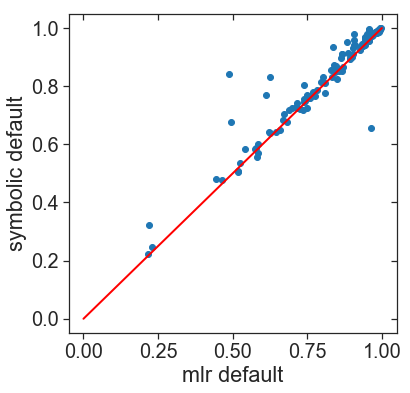

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


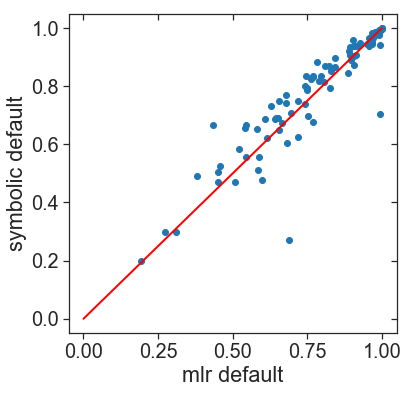

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


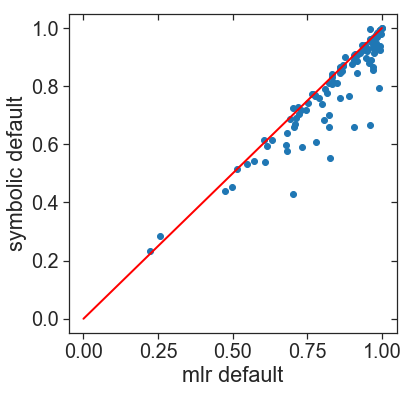

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


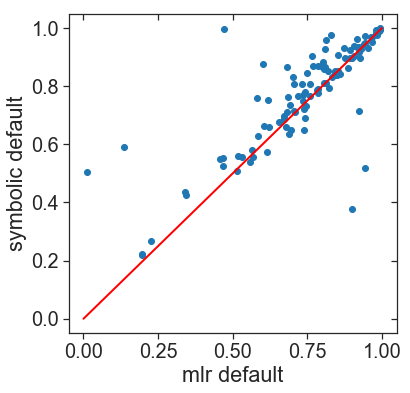

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


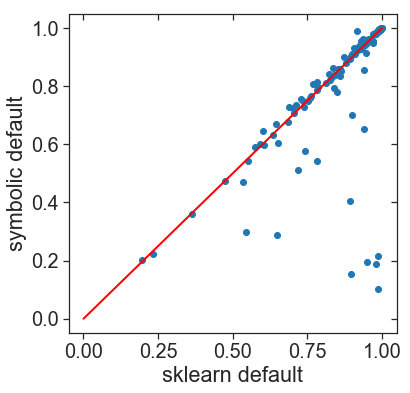

/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1665: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/flo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


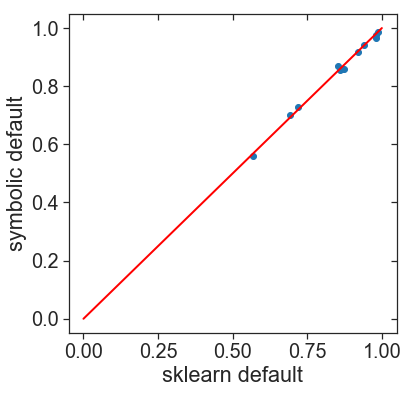

In [18]:
# Scatter plot x mulambda vs constants and perhaps random search
y = ["symbolic default"]

for problem in real_baseline.problem.unique():
    rbsrdf = real_baseline.copy()
    rbsrdf = rbsrdf[rbsrdf["problem"] == problem]
    x = [ys for ys in rbsrdf.search.unique() if ys != y[0]]
    rbsrdf = rbsrdf[rbsrdf.search.isin(x+y)].pivot_table(index="task", columns="search",  values="out")
    if len(rbsrdf) and rbsrdf.shape[1] > 1:
        with sns.plotting_context("notebook", font_scale=1.8):
            grid = sns.JointGrid(rbsrdf[x].values, rbsrdf[y].values, space=0, size=6, ratio=50)
            grid.plot_joint(plt.scatter)
            grid.ax_joint.set_xlabel(*x)
            grid.ax_joint.set_ylabel(*y)
            plt.plot([0.,1.], [0.,1.], "b-", linewidth = 2, color = "red")
            #plt.plot([0.,1.], [0.05,1.05], "b-", linewidth = .5, color = "orange")
            #plt.plot([0.,1.], [-0.05,.95], "b-", linewidth = .5, color = "orange")
            plt.savefig(f"figures/scatter_vs_constants_realdata_{problem}.pdf", bbox_inches='tight', pad_inches=.6)
            plt.show()

## Picking from the Pareto Front

In [19]:
# Collect logs for all problems
problems = ['svm', 'glmnet', 'rf', 'rpart', 'knn']
search_strategies = ["mupluslambda", "random_search", "True"]
log = {}
for problem in problems:
    log[problem] = Runlog(problem, search_strategies, logdir="runs/results2")

In [ ]:
# Get final expression acording to some pick strategy data. 
# Columns 'in' and 'out' refer to in- and out-of-sample performance
df = pd.DataFrame([])

for k in log.keys():
    pdf = log[k].pick_final_expression("cheat")
    pdf['problem'] = k
    df = df.append(pdf)
df[['task', 'length', 'problem', 'search', 'expression', 'in', 'out']].head()

In [ ]:
from collections import Counter
import itertools
# run -> lengths present in pareto
df = get_final_paretofront(log['svm'].data)
df = df[df['expression'].str.contains(',')]
df = df[df.search == "mupluslambda"]
df['maxlength'] = df.groupby(['run', 'search'])['length'].transform(max)
pareto_lengths = df.groupby('run').length.unique()

In [ ]:
df = df.pivot_table(index=["run", "task", "gen", "length", "problem", "search", "expression", 'maxlength'], columns="inout", values="score")
df = df.reset_index()

In [ ]:
best_pareto_solutions = Counter(df[df.groupby(['run', 'search'])['out'].transform(max) == df['out']].length)
all_pareto_solutions = Counter(itertools.chain(*pareto_lengths))

In [ ]:
pfdf = pd.DataFrame([pd.Series(all_pareto_solutions), pd.Series(best_pareto_solutions)]).T.reset_index()
pfdf.columns = ["length", "all", "best"]
pfdf = pd.melt(pfdf, id_vars=["length"], value_vars=["all", "best"])

In [ ]:
sns.barplot(data=pfdf, x="length", y="value", hue="variable")

In [ ]:
best = df[df.groupby(['run', 'search'])['out'].transform(max) == df['out']]

In [ ]:
best_counts = best.groupby(["maxlength", "length"]).count().reset_index()

In [ ]:
import matplotlib.pyplot as plt

a = 0
fig, axes = plt.subplots(4, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    d = best_counts[best_counts.maxlength == i]
    if len(d) > 0:
        sns.barplot(data=d, x="length", y="run", color="blue", ax=ax)
    ax.set_title(f"Max Length {i} ({d.run.sum()})")
    a += d.run.sum()
fig.tight_layout()

In [ ]:
one_best = best.groupby("run").count() == 1
one_best = one_best[one_best['index']]
one_best = best[best.run.isin(one_best.index)]
one_best_counts = one_best.groupby(["maxlength", "length"]).count().reset_index()

a = 0
fig, axes = plt.subplots(4, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    d = one_best_counts[one_best_counts.maxlength == i]
    if len(d) > 0:
        sns.barplot(data=d, x="length", y="run", color="blue", ax=ax)
    ax.set_title(f"Max Length {i} ({d.run.sum()})")
    a += d.run.sum()
fig.tight_layout()

In [ ]:
def try_argmax(group):
    try:
        return group[group.search == "mupluslambda"]["score"].idxmax()
    except:
        return

df2 = df.copy()
for b in range(40):
    b = b/4000
    df["score"] = df2["in"] - b*(df2["length"] - 1.)
    n_wins = sum([try_argmax(group) == group["out"].idxmax() for name, group in df.groupby(["task", "problem"])])
    picked = [group["score"].idxmax() for name, group in df.groupby(["task", "problem", "search"])]
    pickdf = df.loc[picked]
    diffs = pickdf[pickdf.search == "mupluslambda"].groupby("problem")["out"].mean() - pickdf[pickdf.search != "mupluslambda"].groupby("problem")["out"].mean()
    print(f"b = {str(b)}: wins: {str(n_wins)}, perf: {round(diffs.mean(), 3)}")


In [ ]:
df.head()

# END OF WORKING ANALYSIS
Things below are previous / old analysis

### Strategies for picking final individual from the pareto front

In [ ]:
cols = ["task", "problem", "search", "in", "out"]
big_df = pd.DataFrame()
for strat in ["best", "shortest", "relative"]:
    df = log.pick_final_expression(strat, eps=0.01, max_steps=2)[cols]
    bdf = log.get_benchmark_performances().rename(columns={"expression":"search"})[cols]
    df = df.append(bdf)
    df = df[df.search.isin(["mupluslambda", "random_search", "True"])]
    df["strategy"] = strat
    big_df = pd.concat([big_df, df])

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(big_df.groupby(["task", "search",  "strategy"])[["in", "out"]].agg([np.mean, np.median, max, min]))

In [ ]:
sns.boxplot(data=big_df[big_df.search == "mupluslambda"], x="task", y="out", hue="strategy")

# Symbolic Defaults by 'complexity' of expression
In this notebook we take a look at the results of running the script at its default settings, this means:
 - evaluation across all tasks
 - recording the pareto front of symbolic defaults after each search
 - evaluating in-sample and out-of-sample performance of those dynamic defaults, as well as some pre-defined ones
 
**note:** The console cut off results for the first few tasks, so I am rerunning those now.

For each task we will extract:
 - the number of generations optimization ran for (max=200)
 - max length expression
 - in and out of sample performance for length 1, 2 and 3 expression

For each task save the benchmark results. We also save results for length 1, 2 and 3 solutions as well as the best one found (that may be longer). Specifically we record:
 - best in_sample performance at length 1, 2, 3
 - best in_sample performance for any length
 - average out_sample performance by length for length 1, 2, 3
 - average out_sample performance for the longest (i.e. best in-sample score) solution(s).

## Setup
We have experiment data for a set of algorithms and meta-data for the datasets on which the experiments took place.
We use symbolic regression to find an expression for symbolic default values that give good performance across tasks.
Symbolic regression is performed with leave-one-task-out, which means for each algorithm we have multiple searches for a symbolic default, and their performance is recorded for both in-sample (the optimization surface of all-but-one tasks) and out-of-sample (the left out task) performance. Performance here is solely based on surrogate model predictions, no additional experiments have been performed (yet).

In our search, we use NSGA-II selection to perform multi-objective optimization: find the expression with the best performance, while using the fewest number of operators (e.g. `divide`, `multiply`).

### Terms
**Length** of an expression denotes the number of operators in it. A symbolic value is *not* considered an operation.
Consider the following SVM defaults for cost and gamma:
 - `make_tuple`(m, mkd) is length 1.
 - `make_tuple`(m, `truediv`(mkd, xvar)) is length 2.
 - `make_tuple`(16., `truediv`(mkd, xvar)) is length 2.

The **final** solution refers to the symbolic default with the highest in-sample score for a task (regardless of its length). This means for each task there is *at least* one final solution, but there may be more and they are not of a specific length.


The **baseline** solutions are typically the default hyperparameter settings of mlr, scikit-learn, or both.

---

We read all the logs, because some logs are incomplete we have to explicitly give the name of the baselines (this will be fixed for future runs).

In [ ]:
traces = {}

In [ ]:
# Here we analyze the random forest
alg = 'rf'

import os
baselines = dict(
    glmnet=["mlr_default", "sklearn_default"],
    kerasff=["initial_values"],
    knn=["mlr_default"],
    rf=["mlr_default"],
    rpart=["mlr_default"],
    svm=["sklearn_scale", "symbolic_best", "skearn_default", "mlr_default" , "const"],
)
dir_ = "runs/running"
for file in os.listdir(dir_):
    if file.endswith('.log') and alg in file and ('_0.log' in file or '_1.log' in file):
        print(file)
        baseline = []
        for method, bls in baselines.items():
            if method in file:
                baseline = bls
        traces[file[:-4]] = Trace(os.path.join(dir_, file), benchmarks=baseline, ignore=["const", "symbolic_v2"])

### Optimization
As described before, for each problem we find a symbolic default leaving one task out.
We are interested to see how fast the symbolic regression converges across tasks.

In [ ]:
print("Median number of generations across tasks by problem:")
for log, trace in traces.items():
    print(f"{log: <15} {trace.generations_by_task.median().astype(int):3d}")

In [ ]:
traces = {k :v for (k,v) in traces.items() if k not in ["mlr_glmnet_lisa_ints_0", "mlr_glmnet_lisa_ints_1", "mlr_glmnet_lisa_ints_2"]}

In [ ]:
import matplotlib.pyplot as plt
import math

fig, axes = plt.subplots(math.ceil(len(traces) / 4), 4, sharey=True, figsize=(16, 9))
for ax, (log, trace) in zip(axes.flatten(), traces.items()):
    traces[log].generations_by_task.hist(bins=20, ax=ax)
    ax.set_title(f"{log} ({len(trace.generations_by_task)} tasks)")
    ax.set_ylabel('count')
    ax.set_xlabel('generations')
fig.tight_layout()

The plot above shows a histogram counting the number of generations until stopping. These results were obtained with default setting of early stopping if no improvement was made after 20 generations, with a 200 generation maximum.

### Visualizing optimization traces
The traces contain the full optimization traces inside the trace's **progdf** trace.


In [ ]:
# import seaborn as sns
# sns.lineplot(x='gen', y='max', units='task', estimator=None, data=traces[f'{alg}_gauss24_1eph_d1_2'].progdf)
# sns.lineplot(x='gen', y='max', units='task', estimator=None, data=traces[f'{alg}_gauss24_1eph_d1_2i'].progdf)

### Comparing Expressions
For a given problem, we have a Pareto front of solutions for search (=each left out task).
This Pareto front may contain "twins", multiple solutions which performance equally well and have the same length.
Given that the response surface does not differ *that* much when leaving any particular task out, we hope that the symbolic expressions we find are reasonably consistent across searches.
To have some indication of how consistent the results are, for each problem we find the most frequent solutions of length 1, 2 and 3. We also note the number of hyperparameters for which we aim to find a symbolic default, as we expect this to be correlated to how consistent the solutions are:

In [ ]:
expr_count = pd.DataFrame(np.zeros((5, len(traces))), columns=list(traces), index=[1, 2, 3, "#tasks", "params"])
for log, trace in traces.items():  
    for length, expressions in sorted(trace.expressions.items()):
        if 0 < length < 4:
            m = max(set(expressions), key=expressions.count)
            expr_count.loc[length][log] = expressions.count(m)
            # print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")
            if length == 1:
                expr_count.loc["#tasks"][log] = len(trace.scores) / 2
                expr_count.loc["params"][log] = m.count(',') + 1

We can look at the found expressions per problem:

In [ ]:
a = f'{alg}' # run_one #f"mlr_knn_lisa_gaussian" # run_one
for log, trace in traces.items():
    print(log)
    for length, expressions in sorted(trace.expressions.items()):
        if 0 < length < 4:
            m = max(set(expressions), key=expressions.count)
            expr_count.loc[length][log] = expressions.count(m)
            # print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")
            print(f"Most frequent length {length} solution in Pareto front ({expressions.count(m)} times in {len(trace.scores) // 2} tasks):\n     {m}")

## Expression Quality
The expressions we find also need to be good.
Here we compare the following 'strategies':
 - length-*n*: always pick the best expression of length *n*
 - *final*: always pick the best expression, regardless of length
 - *baseline(s)*: compare it to baselines we defined
 
We want to know (all based on out-of-sample performance):
 - which strategy gives the best solution most often?
 - which strategy experiences the least mean regret?
 - which strategy experiences the least median regret?
 
As mentioned before, there can be "twins" in the Pareto front, which means multiple solutions with equal length have equal in-sample performance.
In this case we average the out-of-sample score of those twins.

#### number of wins:

The following table records the number of times a strategy led to the symbolic expression with the best out-of-sample performance (multiple strategies can be the best each task):

In [ ]:
out_comparisons = pd.DataFrame()
for log, trace in traces.items():
    out_comparisons = out_comparisons.append(trace.comparison.loc['either'].rename(log))
out_comparisons

## Regret
Here we look at the regret for a method compared to the best known performance on the dataset from the random search experiments. Per definition the best score in random search is 1 (normalized score).

#### median regret:
The following table records the median regret for a specific strategy compared to picking the best in hindsight:

In [ ]:
# We only evaluate logs where all tasks in subset have completed

full_tasks = [x[0] for x in traces[f"mlr_{alg}_mupluslambda_0"].scores.index]
subset = set(full_tasks[:20])
subset

In [ ]:
medians = {}
for log, trace in traces.items():
    if (subset.issubset(set([x[0] for x in trace.scores.index]))):
        idx = trace.scores.index.map(lambda idx: idx[1] == "out-sample" and idx[0] in subset)
        medians[log] = [(1 - trace.scores[idx].final).median()]
        
for bl in baselines[alg]:
    medians[bl] = [(1 - traces[f"mlr_{alg}_mupluslambda_0"].scores[idx][bl]).median()]
pd.DataFrame.from_dict(medians,orient='index')

In [ ]:
means = {}
for log, trace in traces.items():
    if (subset.issubset(set([x[0] for x in trace.scores.index]))):
        idx = trace.scores.index.map(lambda idx: idx[1] == "out-sample" and idx[0] in subset)
        means[log] = [(1 - trace.scores[idx].final).mean()]
    
for bl in baselines[alg]:
    means[bl] = [(1 - traces[f"mlr_{alg}_mupluslambda_0"].scores[idx][bl]).median()]
pd.DataFrame.from_dict(means,orient='index')

### Results averaged over replications


In [ ]:
# means
pd.DataFrame.from_dict(means,orient='index').groupby(lambda x: ''.join(i for i in x if not i.isdigit())).mean()

In [ ]:
# medians
pd.DataFrame.from_dict(medians,orient='index').groupby(lambda x: ''.join(i for i in x if not i.isdigit())).mean()

### Sanity Checks
Sometimes out-of-sample performance of a baseline may still be better than that of our solution.
However, in-sample performance of our own solutions should always be better than any baseline.
If that is not the case, this would indicate our search does not explore the space well enough.

In [ ]:
in_sample_comparisons = pd.DataFrame()
for log, trace in traces.items():
    in_sample_comparisons = in_sample_comparisons.append(trace.in_comparison.loc['either'].rename(log))
in_sample_comparisons

In [ ]:
ml = traces['mlr_rf_mupluslambda_2']
rs = traces['mlr_rf_random_search_2']

In [ ]:
ml.scores.head()

### Comparison to random search 
The following provides an overview over scores for different iterations of random search

In [ ]:
rsdf = pd.read_csv("data/mlr_"+alg+"_baselines.csv", index_col=0)
rsdf.iloc[:,1:].apply(np.mean,axis=1)

----
End of notebook - just sketchpad below

In [ ]:
trsdf = rsdf.transpose()
trsdf.index.name = "task"
trsdf.index = pd.Index([int(float(x)) for x in trsdf.index.values])

In [ ]:
import seaborn as sns
df = ml.scores.loc[ml.scores.index.map(lambda idx: idx[1] == "out-sample")]
df.index = pd.Index(df.index.map(lambda idx: idx[0]))
df = df.join(trsdf)

In [ ]:
df = df.loc[:,df.median().sort_values().index]
p = sns.boxplot(data=df.melt(), y = "value", x = "variable")
p.set_xticklabels(p.get_xticklabels(), rotation=45)
plt.show(p)

In [ ]:
################ END OF RELEVANT PARTS #################

In [ ]:
alg = "rf"
run_one = f"mlr_{alg}_mupluslambda_0"
minimum = dict(knn=100, svm=100, glmnet=100, rpart=60, rf=25)
final_scores = pd.DataFrame()
for log, trace in traces.items():
    # Filter out runs with >100 tasks completed:
    if len(trace.scores) / 2 > minimum[alg]:
        out_sampfirst_n_tasksle = trace.scores.index.map(lambda idx: idx[1] == "out-sample")
        log_oos = trace.scores.loc[out_sample].final.rename(log)
        final_scores = final_scores.append(log_oos)
        if log == run_one:
            # contains benchmark scores
            for b in trace.baseline:
                baseline_score = trace.scores.loc[out_sample][b].rename(b)
                final_scores = final_scores.append(baseline_score)
final_scores

In [ ]:
# filter out incomplete tasks:
final = final_scores.loc[:, ~final_scores.isna().any()]
df = final

In [ ]:
run_one="mlr_svm_lisa"
run_two="svm_warm"

In [ ]:
df = df.loc[[run_one, run_two]]

In [ ]:
alone = {k: 0 for k in df.index.values}
shared = {k: 0 for k in df.index.values}

for _, out in df.T.iterrows():
    best = out[out == out.max()].index.values
    if len(best) == 1:
        alone[best[0]] += 1
    else:
        for winner in best:
            shared[winner] += 1

alone = {k: alone[k] for k in sorted(alone)}
shared = {k: shared[k] for k in sorted(shared)}
either = {k: shared[k] + alone[k] for k in sorted({**alone, **shared})}
comparison = pd.DataFrame([alone, shared, either], index=['alone', 'shared', 'either'])
comparison


In [ ]:
df_out = df.T.copy()
df_out['max'] = df_out.max(axis=1)
for col in df_out:
    df_out['d_' + col] = df_out['max'] - df_out[col]
d_cols = [c for c in df_out.columns if c.startswith('d_') and 'max' not in c]
df_out[d_cols].mean()

In [ ]:
df_out[d_cols].median()

In [ ]:
ax = (df.loc[run_one] - df.loc[run_two]).hist(bins=[(f / 40 - 1) for f in range(81)])
ax.set_title(f"Symbolic - Constant | median: {(df.loc[run_one] - df.loc[run_two]).median():.3f}, mean: {(df.loc[run_one] - df.loc[run_two]).mean():.3f}, {df.shape[1]} tasks")
ax.set_ylabel("Count")
ax.set_xlabel("Difference")

In [ ]:
sum((df.loc["mlr_svm_lisa"] - df.loc["svm_cst"]) > 0)

In [ ]:
(df.loc["mlr_svm_lisa"] - df.loc["svm_cst"]).mean()

In [ ]:
rsdf.columns = [(round(float(x)), 'out-sample')  for x in rsdf.columns.values

In [ ]:
df = rsdf.append(final_scores)
df.iloc[:,1:].apply(np.mean,axis=1)

In [ ]:
pdf = df.transpose().melt(var_name="method", value_name="performance")
ax = sns.boxplot(x='method', y='performance', data = pdf)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#### mean regret:
The following table records the mean regret for a specific strategy compared to picking the best in hindsight:

In [ ]:
means = pd.DataFrame([])
for log, trace in traces.items():
    m = trace.d_scores.mean().rename(log)
    means = means.append(m)
means[[c for c in medians.columns if 'd_' in c and c != 'd_max']]

### Sketch for future work

**Purpose**
We want to find a set of symbolic defaults $\Theta$ ($\Theta$ = $\{\theta_1, ..., \theta_g\}$) that work well across datasets $1, ..., D$.

This set has to be to be jointly optimal, i.e. $R(\Theta) = \sum_{i=1}^D min(R_i(\theta_1), ..., R_i(\theta_g))$
where $R_i(\theta)$ is the score of configuration $\theta$ on dataset $i$.

**Approach:**
- Evolve a population of $N$ individual formulae using $\mu+\lambda$.
- The population score is the score $R_{pop}$ of a subset of the population of size $g$.
- **Twist**
  Assessing an individual's fitness:
  Use shapely values [2] to assess contribution of an individual to the populations performance.
  Shapely values: Assess contribution of an individual to a groups performance:
  $R_i$ = shap($\theta_i$, $R_{pop}$)
  
- Only solutions that contribute most survive


**Literature**

There is some work under the name of **co-evolution** and **cooperative co-evolution**.
Still have not read through enough of it to be able to .

[1] A Cooperative Coevolutionary Multiobjective Algorithm Using Non-dominated Sorting
    https://delta.cs.cinvestav.mx/~ccoello/EMOO/iorio04.pdf.gz
    
[2] Shapely Values
    https://christophm.github.io/interpretable-ml-book/shapley.html
    
[3] COEVOLUTION EVOLUTIONARY ALGORITHM: A SURVEY
    http://www.ijarcs.info/index.php/Ijarcs/article/view/1657/1645